In [1]:
import os,subprocess
os.environ['CUDA_HOME'] = "/cluster2/huanglab/liquan/apps/CUDA/cuda-11.8/lib64"

import genome_tool
import miaomiao_tool
from motif_tool import load_pwm_from_meme_c,load_pwm_from_meme_c1,CenteredMaxPool1D

%load_ext autoreload
%autoreload 2

In [2]:
from vortex.main.ParallelGatedConvBlock import ParallelGatedConvBlock
from vortex.main.AttentionBlock import AttentionBlock
from vortex.main.RMSNorm import RMSNorm
from vortex.main.HyenaInferenceEngine import fftconv_standard

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from einops import rearrange
import sys,sqlite3,glob,pickle,copy,json
from scipy.stats import spearmanr,pearsonr

# Model Schema

In [4]:
class eSCREEN(nn.Module):
    def __init__(self,kernel_fwd,kernel_rev=None,d_model=32,num_filters=32,seq_length=500,celltype_num=32,mode='sequence',device='cpu',lr=1e-5):
        super().__init__()
        # 定义模型架构
        self.kernel_fwd = kernel_fwd # 正向motif,不可学习
        self.kernel_rev = kernel_rev # 逆向motif,不可学习
        self.pwm_thresh = nn.Parameter(torch.tensor([0.4])) # 认为是motif的最小阈值,可学习
        
        self.d_model = d_model # 特征维度数
        self.seq_length = seq_length # 最长序列长度
        self.celltype_num = celltype_num # 细胞类型数
        
        self.HyenaCluster=nn.ModuleList([ # Hyena模块簇
            self.get_block(
                d_model=d_model,layer_idx=0,num_filters=d_model,num_attention_heads=8,hyena_filter_groups=128,fir_inner_filter_length=7,block_type='HyenaSE'
            ),
            self.get_block(
                d_model=d_model,layer_idx=1,num_filters=d_model,num_attention_heads=8,hyena_filter_groups=128,fir_inner_filter_length=128,block_type='HyenaMR'
            ),
            self.get_block(
                d_model=d_model,layer_idx=2,num_filters=d_model,num_attention_heads=8,block_type='HyenaLI'
            ),
            self.get_block(
                d_model=d_model,layer_idx=3,num_attention_heads=8,block_type='Attention'
            )
        ])
        
        self.motif_embedding    = nn.Linear(self.kernel_fwd.size(0),d_model) # 编码motif的embeding
        self.celltype_embedding = nn.Embedding(num_embeddings=self.celltype_num, embedding_dim=d_model) # 编码celltype的embeding
        self.CenterMaxPool = CenteredMaxPool1D(kernel_size=19, stride=1)
        
        self.header=nn.Sequential(
            nn.Linear(d_model*(seq_length+celltype_num),d_model),
            nn.BatchNorm1d(d_model),
            nn.Linear(d_model,d_model),
            nn.BatchNorm1d(d_model),
            nn.Linear(d_model,1),
        )

        self.device=device
        
    def get_block(self,block_type='HyenaLI',**kwargs):
        if block_type=='HyenaSE':
            return ParallelGatedConvBlock(
                              hidden_size        = kwargs['d_model'],
                              layer_idx          = kwargs['layer_idx'],
                              qkv_proj_bias      = False,
                              hyena_out_proj_bias= True,   
                              state_size  = 16,
                              num_filters = kwargs['num_filters'], # 注意这个参数不能比hidden_size大
                              num_attention_heads= kwargs['num_attention_heads'], # 这个参数和后面的attention层一致即可
                              short_filter_length= 3,
                              short_filter_bias  = False,
                              hyena_filter_groups    = kwargs['hyena_filter_groups'],     # 区分HyenaMR和HyenaSE,不能比d_model更大,需要被d_model整除
                              fir_inner_filter_length= kwargs['fir_inner_filter_length'], # 参数是区分HyenaMR和HyenaSE的关键
                              inner_size_multiple_of = 16,      # 这五个参数是MLP的参数
                              mlp_activation         = 'gelu',  # 这五个参数是MLP的参数
                              evo2_style_activations = True,    # 这五个参数是MLP的参数
                              model_parallel_size    = 1,       # 这五个参数是MLP的参数
                              inner_mlp_size         = 256,     # 这五个参数是MLP的参数
                              column_split_hyena     = False, # 这个是HyenaCascade的参数
                              interleave             = True,  # 这个是HyenaCascade的参数
                              hyena_flip_x1x2        = False, # 这个是HyenaCascade的参数
                              use_flash_depthwise    = False, # 这个是HyenaCascade的参数
                              use_flashfft           = False, # 这个是HyenaCascade的参数
                              prefill_style          = 'fft', # 这个是HyenaCascade的参数
                              bidirectional          = True   # 这个是HyenaCascade的参数
            ).to(torch.bfloat16)
        elif block_type=='HyenaMR':
            return ParallelGatedConvBlock(
                              hidden_size= kwargs['d_model'],
                              layer_idx  = kwargs['layer_idx'],
                              qkv_proj_bias=False,
                              hyena_out_proj_bias=True,
                              state_size = 16,
                              num_filters= kwargs['num_filters'],
                              num_attention_heads    = kwargs['num_attention_heads'], # 这个参数和后面的attention层一致即可
                              short_filter_length    = 3,
                              short_filter_bias      = False,
                              hyena_filter_groups    = kwargs['hyena_filter_groups'],     # 区分HyenaMR和HyenaSE,不能比d_model更大,需要被d_model整除
                              fir_inner_filter_length= kwargs['fir_inner_filter_length'], # 参数是区分HyenaMR和HyenaSE的关键
                              inner_size_multiple_of = 16,     # 这五个参数是MLP的参数
                              mlp_activation         = 'gelu', # 这五个参数是MLP的参数
                              evo2_style_activations = True,   # 这五个参数是MLP的参数
                              model_parallel_size    = 1,      # 这五个参数是MLP的参数
                              inner_mlp_size         = 256,    # 这五个参数是MLP的参数
                              column_split_hyena     = False, # 这个是HyenaCascade的参数
                              interleave             = True,  # 这个是HyenaCascade的参数
                              hyena_flip_x1x2        = False, # 这个是HyenaCascade的参数
                              use_flash_depthwise    = False, # 这个是HyenaCascade的参数
                              use_flashfft           = False, # 这个是HyenaCascade的参数
                              prefill_style          = 'fft', # 这个是HyenaCascade的参数
                              bidirectional          = True   # 这个是HyenaCascade的参数
            ).to(torch.bfloat16)
        elif block_type=='HyenaLI':
            return ParallelGatedConvBlock(
                              hidden_size= kwargs['d_model'],
                              layer_idx  = kwargs['layer_idx'],
                              qkv_proj_bias=False,
                              hyena_out_proj_bias=True,
                              state_size = 16,
                              num_filters= kwargs['num_filters'],
                              num_attention_heads= kwargs['num_attention_heads'], # 这个参数和后面的attention层一致即可
                              short_filter_length= 3,
                              short_filter_bias  = False,
                              proj_groups        = 1,
                              # 没有hyena_filter_groups和fir_inner_filter_length两个参数时就变为HyenaLI
                              # 原来的配置里use_flashfft=False,所以这里也不传递快速卷积模块
                              inner_size_multiple_of =16,     # 这五个参数是MLP的参数
                              mlp_activation         ='gelu', # 这五个参数是MLP的参数
                              evo2_style_activations =True,   # 这五个参数是MLP的参数
                              model_parallel_size    =1,      # 这五个参数是MLP的参数
                              inner_mlp_size         =256,    # 这五个参数是MLP的参数
                              column_split_hyena     = False, # 这个是HyenaCascade的参数
                              interleave             = True,  # 这个是HyenaCascade的参数
                              hyena_flip_x1x2        = False, # 这个是HyenaCascade的参数
                              use_flash_depthwise    = False, # 这个是HyenaCascade的参数
                              use_flashfft           = False, # 这个是HyenaCascade的参数
                              prefill_style          = 'fft', # 这个是HyenaCascade的参数
                              bidirectional          = True   # 这个是HyenaCascade的参数
            ).to(torch.bfloat16)
        elif block_type=='Attention':
            return AttentionBlock(
                              hidden_size        = kwargs['d_model'],
                              num_attention_heads= kwargs['num_attention_heads'],
                              layer_idx          = kwargs['layer_idx'],
                              mha_out_proj_bias  = True,
                              qkv_proj_bias      = False,
                              use_flash_attn     = False,      # 因为cuda的问题(不支持CUDA 12.4),这里不能用flash attention
                              inner_size_multiple_of = 16,     # 这五个参数是MLP的参数
                              mlp_activation         = 'gelu', # 这五个参数是MLP的参数
                              evo2_style_activations = True,   # 这五个参数是MLP的参数
                              model_parallel_size    = 1,      # 这五个参数是MLP的参数
                              inner_mlp_size         = 256     # 这五个参数是MLP的参数
            ).to(torch.bfloat16)
            
    def move(self):
        self.kernel_fwd = self.kernel_fwd.to(self.device)
        self.kernel_rev = self.kernel_rev.to(self.device)
        self.pwm_thresh.data = self.pwm_thresh.data.to(self.device)
        self.motif_embedding.to(self.device)
        self.celltype_embedding.to(self.device)
        self.CenterMaxPool.to(self.device)
        self.header.to(self.device)
        for layer in self.HyenaCluster:
            layer.to(self.device)
        
    def forward(self,x,z):
        
        ### 扫motif,这个时候的形状从原始的(b,l,4)变为(b,4,l)再变为(b, ck, l)      
        x = rearrange( x, 'b l c -> b c l')
        if not self.kernel_rev is None:
            x = fftconv_standard(signal = x,kernel = self.kernel_fwd,bias=None,padding=17,device = self.device) +\
                fftconv_standard(signal = x,kernel = self.kernel_rev,bias=None,padding=17,device = self.device)
        else:
            x = fftconv_standard(signal = x,kernel = self.kernel_fwd,bias=None,padding=17,device = self.device)
        x = nn.functional.relu(x-self.pwm_thresh)
        x = self.CenterMaxPool(x)
        x = rearrange( x, 'b c l -> b l c') # 把通道放到最后一个维度
        x = self.motif_embedding(x)         # 把特征映射到d_model
        z = self.celltype_embedding(z)      # 生成维度为d_model的软嵌入
        
        x  = torch.concatenate([x,z],dim=1) # 把motif嵌入和软嵌入合在一起,形状变为(batch,ls+lc,d_model)

        
        ### 通过stripedHyena层和header层,形状维持(batch,ls+lc,d_model)
        x = x.to(torch.bfloat16)
        for layer in self.HyenaCluster:
            x = layer(x)
            x = nn.functional.relu(x)
            
        ### 最后一步展平嵌入进行打分 
        x = x.to(torch.float).view(x.size(0),-1)
        x = self.header(x).flatten()
        x = nn.functional.sigmoid(x)    
        return torch.clip(x,0,1)

    
    def fit(self,train_loader,valid_loader=None,epochs=200,lr=1e-5,check_step=100,earlystop=20,device='cpu',save_name='./torch_logs/best_model'):
        
        optimizer = torch.optim.Adam(self.parameters(),lr=lr)
        self.device = device
        best_valid_acc = 0.0; count = 0; best_model = None; valid_count = 0
        batch_size = train_loader.batch_size
        for epoch in range(epochs):
            epoch_loss = 0
            for i, batch in enumerate(train_loader):
                x,y,z = batch;x = x.to(device);y = y.to(device);z = z.to(device)
                self.move();self.train()
                optimizer.zero_grad()

                p = self(x,z)

                loss = F.binary_cross_entropy(p,y)
                #loss = F.mse_loss(p,y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                print(f"Step/Epoch [{(i+1)*batch_size}/{epoch+1}], Loss: {avg_loss:.4f}",end='\r')
                
                valid_count += 1
                if valid_count >= check_step:
                    if not valid_loader is None:
                        p,y = self.predict(valid_loader,device=device,verbose=True,with_true=True)
                        valid_acc    = spearmanr(p,y)[0]
                        if valid_acc > best_valid_acc:
                            best_valid_acc = valid_acc
                            count          = 0
                            torch.save(self.state_dict(),save_name+'.best.pt')
                            print(f"Epoch [{epoch+1}], Loss: {avg_loss:.4f}, Val-acc: {valid_acc:.4f} ↑",end='\n')
                        else:
                            count += 1
                            print(f"Epoch [{epoch+1}], Loss: {avg_loss:.4f}, Val-acc: {valid_acc:.4f} -",end='\n')
                            if count > earlystop:
                                print(f'Model early stop in Epoch {epoch+1} with valid Acc {best_valid_acc:.4f}')
                                self.load_state_dict(torch.load(save_name+'.best.pt'))
                                break
                        valid_count = 0
                    else:
                        print("")
                        valid_count = 0
        torch.save(self.state_dict(),save_name+'.final.pt')
        return None
    
    def predict(self,data_loader,device='cpu',verbose=True,with_true=False):
        y_pred=[];y_true=[];self.eval();self.device=device;self.move()
        with torch.no_grad():
            if verbose:
                for batch in tqdm(data_loader, leave=True):
                    if with_true:
                        x,y,z = batch;x = x.to(device);y = y.to(device);z = z.to(device)
                        preds = self.forward(x,z)
                        y_pred.extend(preds.cpu().numpy())
                        y_true.extend(y.cpu().numpy())
                    else:
                        x,y,z = batch;x = x.to(device);z = z.to(device)
                        preds = self.forward(x,z)
                        y_pred.extend(preds.cpu().numpy())
            else:
                for batch in data_loader:
                    if with_true:
                        x,y,z = batch;x = x.to(device);y = y.to(device);z = z.to(device)
                        preds = self.forward(x,z)
                        y_pred.extend(preds.cpu().numpy())
                        y_true.extend(y.cpu().numpy())
                    else:
                        x,y,z = batch;x = x.to(device);z = z.to(device)
                        preds = self.forward(x,z)
                        y_pred.extend(preds.cpu().numpy()) 
                    
        return np.array(y_pred),np.array(y_true)

# Load Data

In [6]:
K562_Demo_Dataset = pd.read_csv('/cluster2/huanglab/liquan/data/eSCREEN/ANLYSIS/code/StripedHyena/dataset/exps146_withreadout.txt',sep='\t')
K562_Demo_Dataset = K562_Demo_Dataset[K562_Demo_Dataset['cell_line']=='K562']
K562_Demo_Dataset = K562_Demo_Dataset.groupby(['id','chr','start','end']).agg({'RRA':'max','p':'max'}).reset_index()
import pyBigWig as pybw
with pybw.open('/cluster2/huanglab/liquan/data/K562/H3K27ac.bigWig') as k27ac,pybw.open('/cluster2/huanglab/liquan/data/K562/DNase.bigWig') as dnase:
    for rw in tqdm(K562_Demo_Dataset.itertuples(),total=len(K562_Demo_Dataset)):
        K562_Demo_Dataset.at[rw.Index,'dnase']=dnase.stats(rw.chr,rw.start,rw.end,type='mean')[0]
        K562_Demo_Dataset.at[rw.Index,'k27ac']=k27ac.stats(rw.chr,rw.start,rw.end,type='mean')[0]

100%|██████████| 400244/400244 [01:04<00:00, 6175.24it/s]


In [7]:
from pyfaidx import Fasta
pos = K562_Demo_Dataset[ (K562_Demo_Dataset['RRA']>2) & (K562_Demo_Dataset['p']>2) ]
pos['label'] = 1
pos['cell_type'] = 'K562'
neg = K562_Demo_Dataset[ (K562_Demo_Dataset['RRA']<1) & (K562_Demo_Dataset['p']<1) ].sort_values(by=['dnase','k27ac']).iloc[:len(pos)]
neg['label'] = 0
neg['cell_type'] = 'K562'
table = pd.concat([pos,neg]).reset_index(drop=True)
tqdm.pandas(desc="Processing sequences", leave=True)
with Fasta('/cluster2/huanglab/liquan/genome_ref/hg38.fa') as hg38:
    table['sequence'] = table.progress_apply(lambda x: hg38[x.chr][x.start:x.end].seq.upper(),axis=1)
table['one hot'] = table['sequence'].progress_apply(lambda x: genome_tool.one_hot(x))

/cluster2/huanglab/liquan/temp/Rtemp/ipykernel_4014881/441334972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['label'] = 1
/cluster2/huanglab/liquan/temp/Rtemp/ipykernel_4014881/441334972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['cell_type'] = 'K562'
Processing sequences: 100%|██████████| 36664/36664 [00:19<00:00, 1854.22it/s]


In [ ]:
from sklearn.model_selection import train_test_split

trainset,testset = train_test_split(table, test_size=0.2, random_state=114514)
testset,validset = train_test_split(testset, test_size=0.5, random_state=114514)
print(len(trainset),len(testset),len(validset))

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, df, ct_dict, x_col_name='one hot', y_col_name='label', z_col_name='cell_type', max_len=500):
        self.df = df
        self.ct_dict = ct_dict
        self.x_col_name = x_col_name
        self.y_col_name = y_col_name
        self.z_col_name = z_col_name
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq = self.df.iloc[idx][self.x_col_name][:self.max_len]
        target = self.df.iloc[idx][self.y_col_name]
        celltype = self.df.iloc[idx][self.z_col_name]
        x = torch.tensor(np.stack(seq), dtype=torch.float)
        y = torch.tensor(float(target), dtype=torch.float)
        z = torch.tensor(self.ct_dict[celltype],dtype=torch.long)
        return x, y, z

In [7]:
import pickle
with open('./data/K562_demo_dataset.pkl','rb') as file:
    K562_Demo_Dataset = pickle.load(file)
    
trainset = K562_Demo_Dataset['Trainset']
testset  = K562_Demo_Dataset['Testset']
validset = K562_Demo_Dataset['Validset']

train_ds = SequenceDataset(trainset, cell_type_dict)
test_ds  = SequenceDataset(testset , cell_type_dict)
valid_ds = SequenceDataset(validset, cell_type_dict)

train_loader = DataLoader(train_ds , batch_size=16)
test_loader  = DataLoader(test_ds  , batch_size=16)
valid_loader = DataLoader(valid_ds , batch_size=16)

## Train

In [ ]:
motifs_f, motifs_r, motif_names, motif_length = load_pwm_from_meme_c(
    "/cluster2/huanglab/liquan/motif/consensus_pwms.meme", max_length=35
)
seed = 114514
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 禁用cudnn非确定性算法
torch.backends.cudnn.benchmark = False     # 关闭自动寻找最优卷积算法
kernel_fwd  = torch.tensor(motifs_f,dtype=torch.float)
kernel_rev  = torch.tensor(motifs_r,dtype=torch.float)
d_in = None
d_model = 512
num_filters = 512

model = eSCREEN(
    kernel_fwd = kernel_fwd,kernel_rev = kernel_rev,d_model=d_model,
    num_filters=num_filters,seq_length=500,celltype_num=32,lr=1e-5,device='cuda:1',
)

with open('/cluster2/huanglab/liquan/data/eSCREEN/ANLYSIS/code/StripedHyena/torch_logs/MIX_mix_celltype.dict','r') as file:
    cell_type_dict = json.load(file)

In [ ]:
torch.cuda.empty_cache()
model.fit(train_loader,test_loader,epochs=10,lr=1e-4,check_step=500,earlystop=20,device='cuda:0',save_name='./K562_model')
model.load_state_dict( torch.load('./K562_model.best.pt') )

## Prediction & Evaluation

In [10]:
p,y = model.predict(valid_loader,device='cuda:0',verbose=True,with_true=True)
print( round(spearmanr(p,y)[0],4),round(pearsonr(p,y)[0],4) )

100%|██████████| 230/230 [00:07<00:00, 30.83it/s]

0.6879 0.7076


AUC: 0.8972
MCC: 0.6559
F1 Score: 0.8294
Accuracy: 0.8279
Recall: 0.8243
Precision: 0.8346


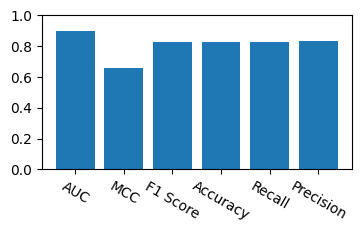

In [20]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

predictions = p;labels = y
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

# 计算指标
auc_val = auc(roc_curve(labels, predictions)[0],roc_curve(labels, predictions)[1])
mcc = matthews_corrcoef(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
accuracy = accuracy_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)

# 输出结果
print(f"AUC: {auc_val:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(4,2))
plt.bar([1,2,3,4,5,6],[auc_val,mcc,f1,accuracy,recall,precision])
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6],["AUC","MCC","F1 Score","Accuracy","Recall","Precision"],rotation=-30)
plt.show()